# Logistic Regression analysis on Titanic dataset

## Use of data visualization, feature engineering, and feature selection to make a simple logistic regression look powerful


## Imports

In [1]:
# libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Functions

In [2]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [3]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [4]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

In [6]:
# Import data
df = pd.read_csv('train.csv')
df_raw = df.copy()

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



* **PassengerId**. Unique identification of the passenger.
* **Survived**. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.
* **Pclass**. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd). Ready to go.
* **Name**. Name of the passenger. We need to parse before using it.
* **Sex**. Sex. Categorical variable that should be encoded.
* **Age**. Age in years. Ready to go.
* **SibSp**. # of siblings / spouses aboard the Titanic. Ready to go.
* **Parch**. # of parents / children aboard the Titanic. Ready to go.
* **Ticket**. Ticket number.
* **Fare**. Passenger fare. Ready to go.
* **Cabin**. Cabin number.
* **Embarked**. Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). Categorical feature that should be encoded.

**Conlusion:**
we already have a set of features that we can easily use in our machine learning model. Features like 'Name', 'Ticket', and 'Fare' requires effort.

In [8]:
# Descriptive statistics
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Analyse missing data
draw_missing_data_table(df)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [10]:
# Droping Cabin due to very high missing vales 
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [11]:
# Filling missing values in Age with a specific value
value = 1000
df['Age'].fillna(1000, inplace=True)
df['Age'].max()

1000.0

In [12]:
# Delete observations without Embarked
df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True)
df[pd.isnull(df['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


### Preparing the data

In [13]:
# Data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [14]:
# Drop PassengerId
df.drop('PassengerId', axis=1, inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [15]:
# Define categorical variables
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])

In [16]:
# Creating Family feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [17]:
# Droping SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0


In [18]:
# Droping Name and Ticket
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [19]:
# Transforming categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)
df.head()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,1,0,1
1,1,1,38.0,71.2833,1,0,0,0
2,1,3,26.0,7.9250,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,1


In [20]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [21]:
# Debug
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
      Pclass     Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S
121       3  1000.0    8.0500           0         1           0           1
687       3    19.0   10.1708           0         1           0           1
790       3  1000.0    7.7500           0         1           1           0
837       3  1000.0    8.0500           0         1           0           1
659       1    58.0  113.2750           2         1           0           0
Outputs: 
 121    0
687    0
790    0
837    0
659    0
Name: Survived, dtype: int64


In [22]:
# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.786 +/- 0.031


### Assessing model performance

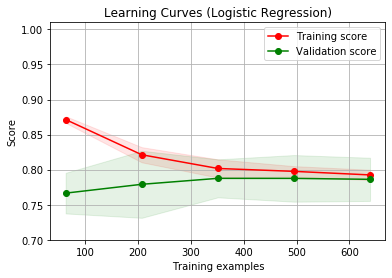

In [24]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

Results and discussion:
* The model doesn't overfit. As we can see, the curves converge and no gap between the training and the validation score exists in the last points of the curve.
* The model underfits. Our final score is about 0.786.

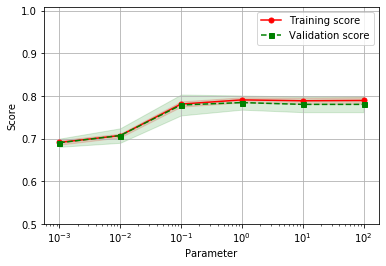

In [25]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range);

* Validation curves helps in improving the performance of our model. In particular, to tune the hyperparameters.
* Validation curves differ from learning curves. The goal of validation curves is to see how the hyperparameters impact the training and validation scores.
* Once again, if there is a gap between the training and the validation score, the model is probably overfitting. By contrast, if there is no gap but the score values are low, we can say that the model underfits.


The model represents: 
* Achieved a 0.786 +/- 0.026 accuracy.
* It is based on a logistic regression.
* Used 'Pclass', 'Age', 'Fare', 'FamilySize', 'Sex', and 'Embarked as inputs; and 'Survived' as output.

Results:
* The figure shows that the C value of $10^{-1}$ or higher, the model's performance is similar. C is the only hyperparameter that we can change as per the use of logistic regression.

In [26]:
# Restarting data set
df = df_raw.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
# Family size feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [28]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [29]:
# Droping irrelevant features
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0


## Imputation of 'Age' missing data

In [30]:
# Inspect names
df_raw['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

* The rule seems to be: *'last name'* + *','* + *'title'* + *'other names'*

In [31]:
# Extracting titles from name
df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [32]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

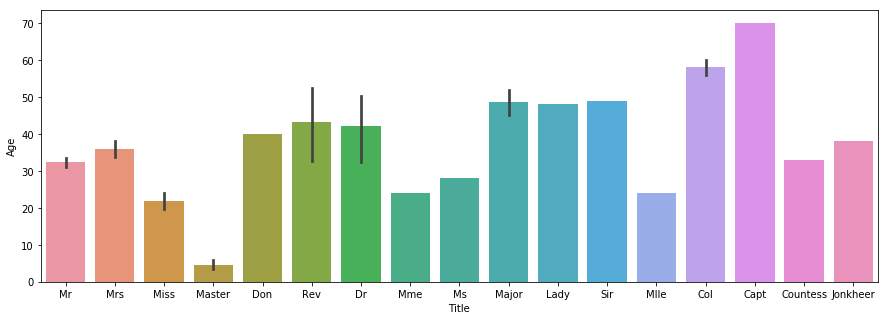

In [54]:
plt.figure(figsize=(15,5))
sns.barplot(x=df['Title'], y=df_raw['Age']);

In [33]:
# Mean values per title
df_raw['Title'] = df['Title']
means = df_raw.groupby('Title')['Age'].mean()
means.head()

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Name: Age, dtype: float64

In [34]:
# Transform means into a dictionary for mapping
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [35]:
# Impute ages based on titles
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age,'Age'].loc[idx_nan_age] = df['Title'].loc[idx_nan_age].map(map_means)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [36]:

df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Imputed
0,1,0,3,male,22.0,7.2500,S,1,Mr,0
1,2,1,1,female,38.0,71.2833,C,1,Mrs,0
2,3,1,3,female,26.0,7.9250,S,0,Miss,0
3,4,1,1,female,35.0,53.1000,S,1,Mrs,0
4,5,0,3,male,35.0,8.0500,S,0,Mr,0


## Exploratory data analysis

### Pclass

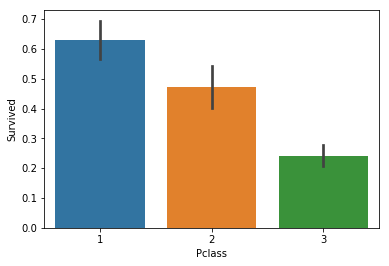

In [59]:
sns.barplot(df['Pclass'],df['Survived']);

* 60% of the people travelling in the first class survived. 
* 25% of the people travelling in the third class survived. 
* Plot suggests that travel class affects the survival chances.

### Name/Title

In [60]:
df.groupby(['Title'])['PassengerId'].count()

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: PassengerId, dtype: int64

* 'Master', 'Miss', 'Mr', and 'Mrs', appear several times. 
* 'Mme' and 'Mlle', correspond to 'Mrs' and 'Miss'.
* We will group all the remaining titles in a new title named 'Other'.

In [37]:
# Map of aggregated titles:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

In [38]:
df['Title'] = df['Title'].map(titles_dict)
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [39]:
df['Title'] = pd.Categorical(df['Title'])
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex              object
Age             float64
Fare            float64
Embarked         object
FamilySize        int64
Title          category
Imputed           int64
dtype: object

In [40]:
draw_missing_data_table(df)

,Total,Percent
Age,177,0.198653
Title,2,0.002245
Embarked,2,0.002245
Imputed,0,0.000000
FamilySize,0,0.000000
Fare,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000
PassengerId,0,0.000000


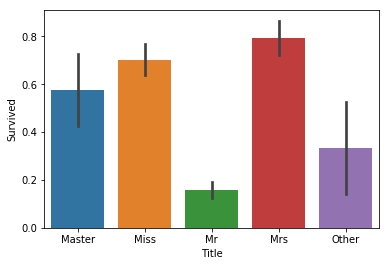

In [64]:
sns.barplot(x='Title', y='Survived', data=df);

* People with the title 'Mr' survived less than people with any other title. 
* Titles with a survival rate higher than 50% are those that correspond to female (Miss or Mrs) or children (Master) titles.
* Our new category, 'Other', doesn't work very well.  
* The category 'Master' also seems to have some uncertainty 

### Sex

In [65]:
# Transform into categorical
df['Sex'] = pd.Categorical(df['Sex'])

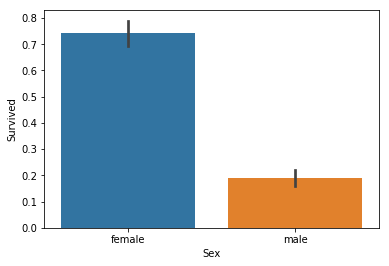

In [66]:
# Plot
sns.barplot(df['Sex'],df['Survived']);

### Age

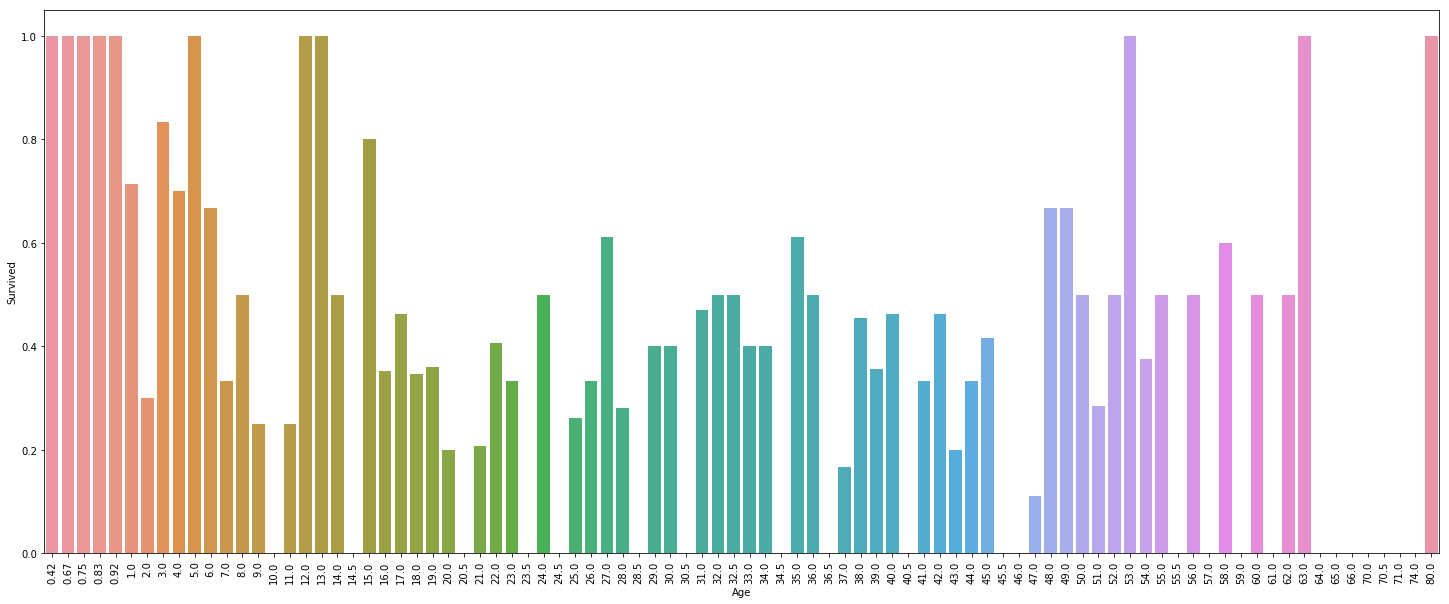

In [67]:
# Plot
plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)
plt.xticks(rotation=90);

Plotting into three regions for the age group: 

1. Age between 0 and 15. 
1. Age between 15 and 48.
1. Age between 48 and 80. 


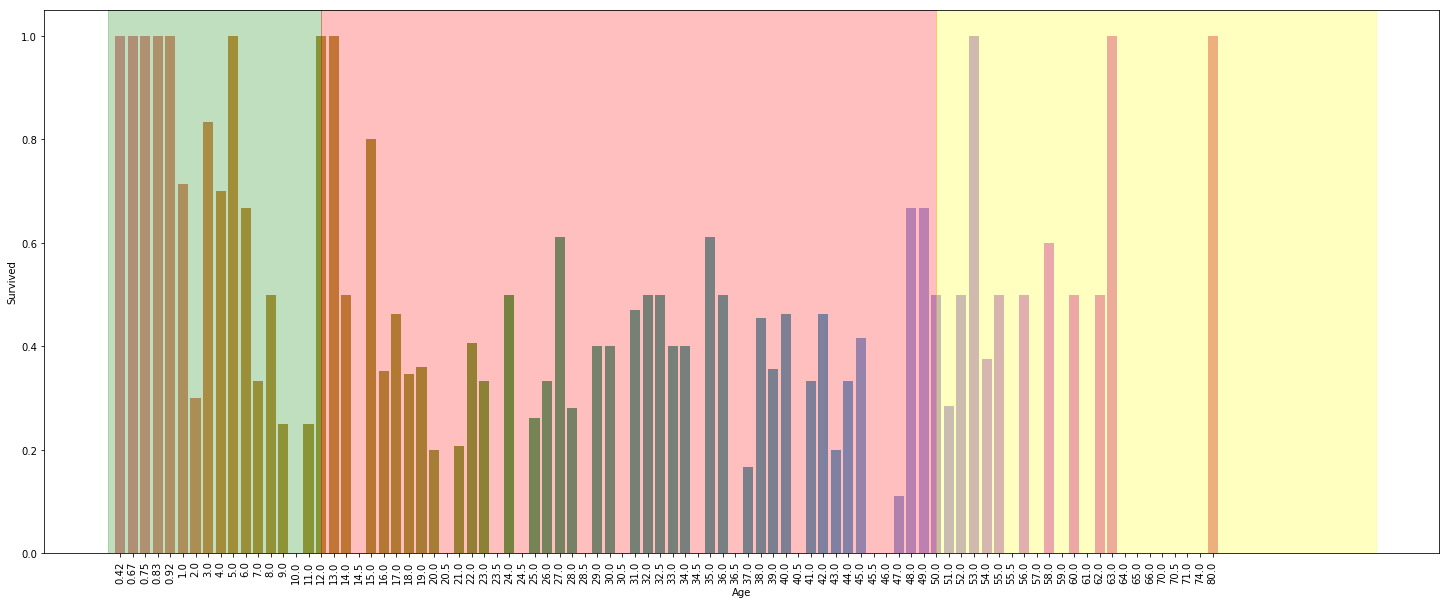

In [68]:
limit_1 = 12
limit_2 = 50

x_limit_1 = np.size(df[df['Age'] < limit_1]['Age'].unique())
x_limit_2 = np.size(df[df['Age'] < limit_2]['Age'].unique())

plt.figure(figsize=(25,10))
sns.barplot(df['Age'],df['Survived'], ci=None)

plt.axvspan(-1, x_limit_1, alpha=0.25, color='green')
plt.axvspan(x_limit_1, x_limit_2, alpha=0.25, color='red')
plt.axvspan(x_limit_2, 100, alpha=0.25, color='yellow')

plt.xticks(rotation=90);

In [41]:
# Bining data
df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])
df['Age'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age, dtype: category
Categories (3, object): [Child < Adult < Elder]

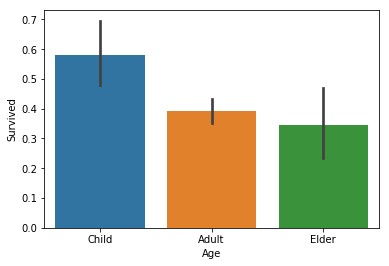

In [70]:
sns.barplot(df['Age'], df['Survived']);

* Children have a higher survival rate. 
* No difference between the classes 'Adult' and 'Elder'.

### FamilySize

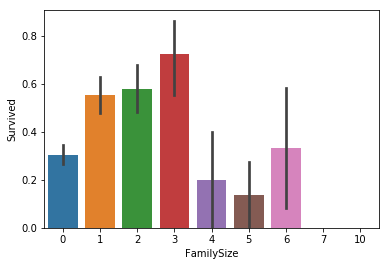

In [71]:
sns.barplot(df['FamilySize'], df['Survived']);

* 'FamilySize' is between 0 and 3 have high chances of survival. 
* People travelling alone have a lower survival rate than people travelling in family. 

### Fare

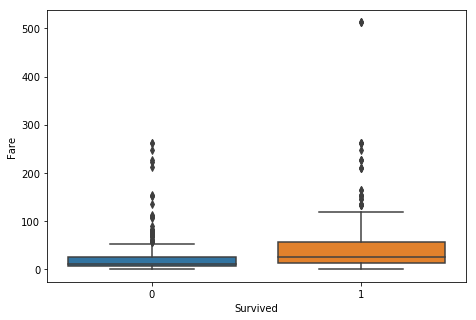

In [72]:
-plt.figure(figsize=(7.5,5))
sns.boxplot(df['Survived'], df['Fare']);

* The plot suggests that those who survived paid a higher fare.

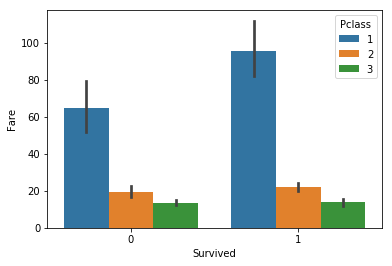

In [73]:
sns.barplot(df['Survived'], df['Fare'], df['Pclass']);

* If you're travelling in first class, higher fares lead to higher survival chances.

### Embarked

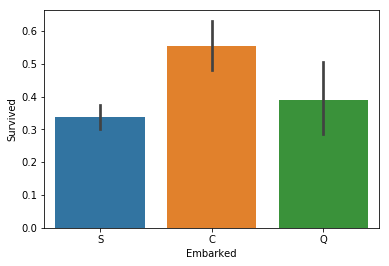

In [74]:
sns.barplot(df['Embarked'], df['Survived']);

* People embarking on C were selected by a superior entity to survive.

In [75]:
# Compare with other variables
df.groupby(['Embarked']).mean()

,PassengerId,Survived,Pclass,Fare,FamilySize,Imputed
Embarked,,,,,,
C,445.357143,0.553571,1.886905,59.954144,0.750000,0.226190
Q,417.896104,0.389610,2.909091,13.276030,0.597403,0.636364
S,449.527950,0.336957,2.350932,27.079812,0.984472,0.139752


* It seems that people embarking on C were paying more and traveling in higher class than people embarking on Q and S.

In [76]:
# Relationship with age
df.groupby(['Embarked','Age'])['PassengerId'].count()

Embarked  Age  
C         Child     11
          Adult    104
          Elder     15
Q         Child      4
          Adult     21
          Elder      3
S         Child     54
          Adult    455
          Elder     45
Name: PassengerId, dtype: int64

* No significant differences can be found.

In [77]:
# Relationship with sex
df.groupby(['Embarked','Sex'])['PassengerId'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     36
          male       41
S         female    203
          male      441
Name: PassengerId, dtype: int64

* The female/male ratio is higher in C and Q than in S.

## Feature extraction

### Feature engineering

#### Data preparation

In [42]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Imputed
0,1,0,3,male,Adult,7.2500,S,1,Mr,0
1,2,1,1,female,Adult,71.2833,C,1,Mrs,0
2,3,1,3,female,Adult,7.9250,S,0,Miss,0
3,4,1,1,female,Adult,53.1000,S,1,Mrs,0
4,5,0,3,male,Adult,8.0500,S,0,Mr,0


In [43]:
# Drop feature
df.drop('PassengerId', axis=1, inplace=True)

In [44]:
# Check features type
df.dtypes

Survived         int64
Pclass           int64
Sex             object
Age           category
Fare           float64
Embarked        object
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [45]:
# Transform object into categorical
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df.dtypes

Survived         int64
Pclass        category
Sex             object
Age           category
Fare           float64
Embarked      category
FamilySize       int64
Title         category
Imputed          int64
dtype: object

In [46]:
# Transform categorical features into dummy variables
df = pd.get_dummies(df, drop_first=1)  
df.head()

,Survived,Fare,FamilySize,Imputed,Pclass_2,Pclass_3,Sex_male,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,7.2500,1,0,0,1,1,1,0,0,1,0,1,0,0
1,1,71.2833,1,0,0,0,0,1,0,0,0,0,0,1,0
2,1,7.9250,0,0,0,1,0,1,0,0,1,1,0,0,0
3,1,53.1000,1,0,0,0,0,1,0,0,1,0,0,1,0
4,0,8.0500,0,0,0,1,1,1,0,0,1,0,1,0,0


In [47]:
from sklearn.model_selection import train_test_split

X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

#### Box-Cox transformations

In [48]:
from scipy.stats import boxcox

X_train_transformed = X_train.copy()
X_train_transformed['Fare'] = boxcox(X_train_transformed['Fare'] + 1)[0]
X_test_transformed = X_test.copy()
X_test_transformed['Fare'] = boxcox(X_test_transformed['Fare'] + 1)[0]

#### Polynomials

In [49]:
# Rescale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [50]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2).fit(X_train_transformed)
X_train_poly = poly.transform(X_train_transformed_scaled)
X_test_poly = poly.transform(X_test_transformed_scaled)

In [51]:
print(poly.get_feature_names())

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x9 x13', 'x10^2', 'x10 x11', '

### Feature selection

In [52]:
# Select features using chi-squared test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Getting score using original model
logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy (original): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
highest_score = np.mean(scores)

# Getting score using models with feature selection
for i in range(1, X_train_poly.shape[1]+1, 1):
    # Select i features
    select = SelectKBest(score_func=chi2, k=i)
    select.fit(X_train_poly, y_train)
    X_train_poly_selected = select.transform(X_train_poly)

    # Model with i features selected
    logreg.fit(X_train_poly_selected, y_train)
    scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
    print('CV accuracy (number of features = %i): %.3f +/- %.3f' % (i, 
                                                                     np.mean(scores), 
                                                                     np.std(scores)))
    
    # Save results if best score
    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_score = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i
        
# Print the number of features
print('Number of features when highest score: %i' % k_features_highest_score)

CV accuracy (original): 0.827 +/- 0.029
CV accuracy (number of features = 1): 0.789 +/- 0.046
CV accuracy (number of features = 2): 0.789 +/- 0.046
CV accuracy (number of features = 3): 0.789 +/- 0.046
CV accuracy (number of features = 4): 0.789 +/- 0.046
CV accuracy (number of features = 5): 0.789 +/- 0.046
CV accuracy (number of features = 6): 0.789 +/- 0.046
CV accuracy (number of features = 7): 0.785 +/- 0.042
CV accuracy (number of features = 8): 0.785 +/- 0.042
CV accuracy (number of features = 9): 0.785 +/- 0.042
CV accuracy (number of features = 10): 0.798 +/- 0.038
CV accuracy (number of features = 11): 0.798 +/- 0.038
CV accuracy (number of features = 12): 0.798 +/- 0.038
CV accuracy (number of features = 13): 0.798 +/- 0.038
CV accuracy (number of features = 14): 0.798 +/- 0.038
CV accuracy (number of features = 15): 0.798 +/- 0.038
CV accuracy (number of features = 16): 0.796 +/- 0.036
CV accuracy (number of features = 17): 0.796 +/- 0.036
CV accuracy (number of features = 

---

## Fitting model for best feature combination

In [53]:
# Select features
select = SelectKBest(score_func=chi2, k=k_features_highest_score)
select.fit(X_train_poly, y_train)
X_train_poly_selected = select.transform(X_train_poly)

In [54]:
# Fit model
logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train_poly_selected, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
# Model performance
scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.829 +/- 0.035


## Learning curve

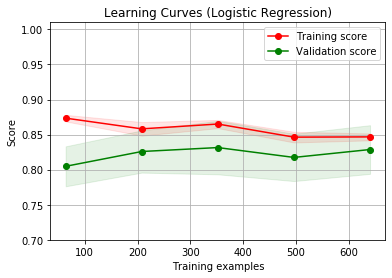

In [56]:
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train_poly_selected, 
                    y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

* No signs of overfitting or underfitting.

## Validation curve

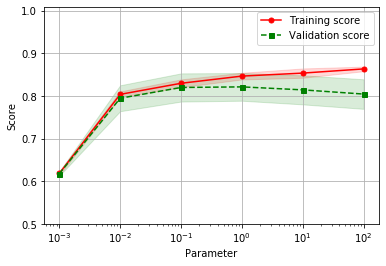

In [57]:
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train_poly_selected, y=y_train, 
                      param_name=param_name, ylim=(0.5, 1.01), param_range=param_range);

We used C=1, which is on the edge of overfitting. Regarding underfitting, there are no signs of it since the model performs well.

## Predictions

In [60]:
# Test Data 
df = pd.read_csv('test.csv')
df_raw = df.copy()

In [61]:

df['FamilySize'] = df['SibSp'] + df['Parch']
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)
    
df_raw['Title'] = df['Title']  
means = df_raw.groupby('Title')['Age'].mean()
map_means = means.to_dict()

idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age, 'Age'] = df['Title'].loc[idx_nan_age].map(map_means)
df['Title'] = df['Title'].map(titles_dict)
df['Title'] = pd.Categorical(df['Title'])

df['Imputed'] = 0
df.at[idx_nan_age.values, 'Imputed'] = 1

df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

passenger_id = df['PassengerId'].values
df.drop('PassengerId', axis=1, inplace=True)
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
d
f = pd.get_dummies(df, drop_first=1)

df = df.fillna(df.mean())  # There is one missing value in 'Fare'

X = df[df.loc[:, df.columns != 'Survived'].columns]

X_transformed = X.copy()
X_transformed['Fare'] = boxcox(X_transformed['Fare'] + 1)[0]

scaler = MinMaxScaler()
X_transformed_scaled = scaler.fit_transform(X_transformed)

poly = PolynomialFeatures(degree=2).fit(X_transformed)
X_poly = poly.transform(X_transformed_scaled)
X_poly_selected = select.transform(X_poly)

In [62]:
# Making predictions
predictions = logreg.predict(X_poly_selected)

In [64]:
# Generate submission file
submission = pd.DataFrame({ 'PassengerId': passenger_id,
                            'Survived': predictions})
submission.to_csv('submission.csv', index=False)